In [1]:
% matplotlib inline
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize': 16, 'axes.labelsize': 20, 'axes.titlesize': 20,
             'xtick.labelsize': 12, 'ytick.labelsize':12, 'figure.figsize': (7.5, 7.5),}
plt.rcParams.update(pltparams)

In [2]:
## You may install pandas-datareader by typing the following command in command prompt
## conda install pandas-datareader
import pandas as pd # import pandas library as pd
from datetime import datetime
from pandas_datareader import data as pdr
from pandas_datareader import wb   as pwb

In [3]:
# Logarithmic return of price time series
def logreturn(Pt,tau=1):
    return np.log(Pt[tau:]) - np.log(Pt[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
# normalize data to have unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return (data/np.sqrt(np.var(data)))
# compute normalized probability distribution function
def pdf(data,bins=50):
    hist, edges = np.histogram(data[~np.isnan(data)], bins=bins, density=True) # remove NaNs and compute histogram (returns bar heights and bar edges)
    edges   = (edges[:-1] + edges[1:])/2.0 # get bar centers
    nonzero = hist > 0.0                   # only keep non-zero points 
    return edges[nonzero], hist[nonzero]

In [4]:
def read_yahoo_data(fname):
    return pd.read_csv(fname, index_col=0, na_values="null").dropna()

toyota     = read_yahoo_data('./yahoo_finance/TM.csv')
mitsui     = read_yahoo_data('./yahoo_finance/MITSY.csv')
mitsubishi = read_yahoo_data('./yahoo_finance/MTU.csv')
apple      = read_yahoo_data('./yahoo_finance/AAPL.csv')
msft       = read_yahoo_data('./yahoo_finance/MSFT.csv')
hpq        = read_yahoo_data('./yahoo_finance/HPQ.csv')
nikkei     = read_yahoo_data('./yahoo_finance/^N225.csv')
sp500      = read_yahoo_data('./yahoo_finance/^GSPC.csv')
toyota.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-27,104.980003,105.029999,104.480003,104.540001,104.540001,218900.0
2017-06-28,104.989998,105.349998,104.769997,105.309998,105.309998,193300.0
2017-06-29,105.120003,105.120003,103.839996,104.339996,104.339996,182700.0
2017-07-03,105.800003,106.339996,105.650002,106.029999,106.029999,165700.0
2017-07-05,108.150002,108.779999,108.099998,108.529999,108.529999,493178.0


In [6]:
# add logarithmic return data to pandas DataFrame data using the 'Adjusted Close' stock price for each day
def computeReturn(data, name, tau):
    data[name]=pd.Series(normalized(logreturn(data['Adj Close'].values, tau)),index=data.index[:-tau])
for stock in [toyota,mitsui,mitsubishi,nikkei,apple,msft,hpq,sp500]:
    computeReturn(stock,'Return d1',1)

In [19]:
apple = apple[(apple.index >= '19890101') & (apple.index <= '20161231')]
apple.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6805 entries, 1990-01-02 to 2016-12-30
Data columns (total 10 columns):
Open              6805 non-null float64
High              6805 non-null float64
Low               6805 non-null float64
Close             6805 non-null float64
Adj Close         6805 non-null float64
Volume            6805 non-null float64
Return d1         6805 non-null float64
Return tau 30     6805 non-null float64
Return tau 90     6805 non-null float64
Return tau 180    6752 non-null float64
dtypes: float64(10)
memory usage: 584.8+ KB


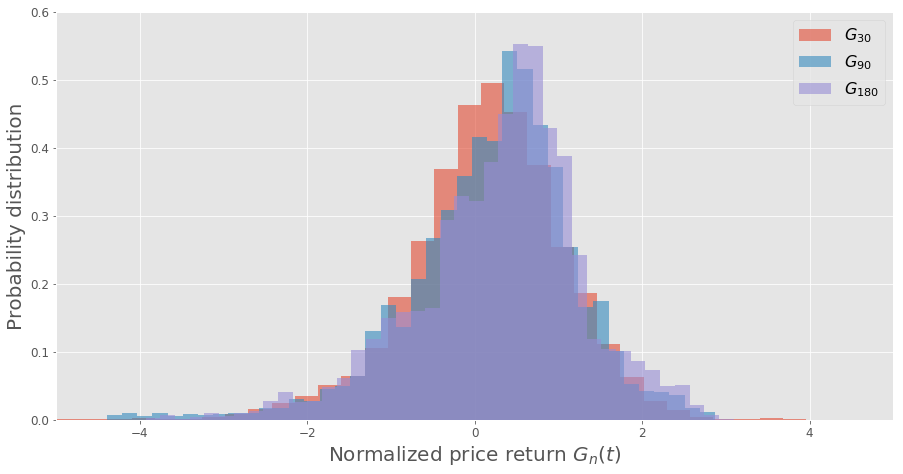

In [20]:
# Problem 1
fig,bx=plt.subplots(figsize=(15.0,7.5))
# compute returns for tau = 30, 90, 180 days
for tau,lbl in zip([30, 90, 180],['$G_{30}$', '$G_{90}$', '$G_{180}$']):
    computeReturn(apple, 'Return tau ' + str(tau), tau)
    apple['Return tau ' + str(tau)].hist(ax=bx, alpha=0.6, normed=True, bins=40, lw=0, label=lbl)
x = np.linspace(-5,5)
bx.legend()
bx.set_xlabel('Normalized price return $G_n(t)$')
bx.set_ylabel('Probability distribution')
bx.set_xlim([-5,5])
bx.set_ylim([0,0.6])
plt.show()

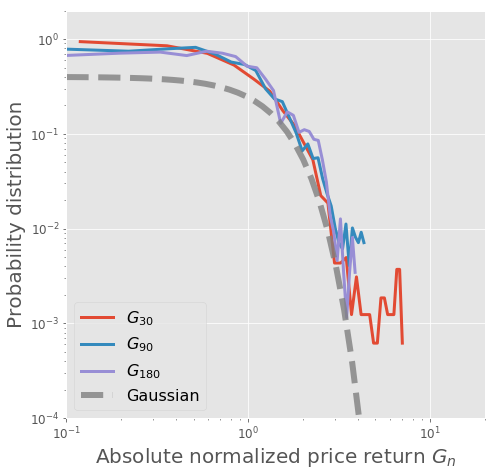

In [22]:
# Problem 2
fig,ax=plt.subplots(subplot_kw={'xlabel':r'Absolute normalized price return $G_n$','ylabel':r'Probability distribution'})
# probability distribution for stocks
for tau, lbl in zip([30, 90, 180],['$G_{30}$', '$G_{90}$', '$G_{180}$']):
    edges,hist=pdf(np.abs(apple['Return tau ' + str(tau)]),bins=30)
    ax.plot(edges,hist,label=lbl,lw=3)
x = np.logspace(-1, 1.2)
ax.plot(x,np.abs(np.exp(-x**2/2)/np.sqrt(2*np.pi)),lw=6,ls='--',color='gray',alpha=0.8,label=r'Gaussian')
ax.semilogy()
ax.semilogx()
ax.set_ylim(1e-4, 2e0)
ax.set_xlim(1e-1, 2e1)
ax.legend(loc=3, fontsize=16, framealpha=0.8)
plt.show()

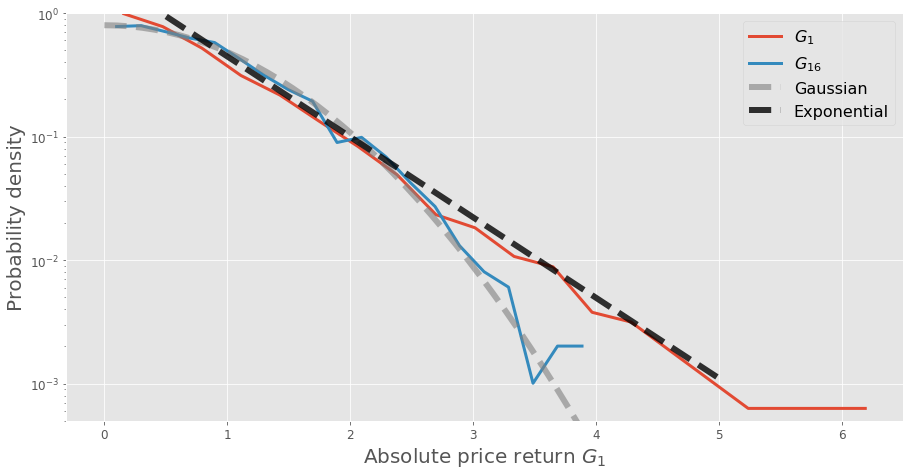

In [26]:
# Problem 4
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2} # define model parameters
def model1(params,p0,numt):                # simulate dealer model for numt ticks
    mktprice = np.zeros(numt)              # initialize array for market prices
    ticktime = np.zeros(numt,dtype=np.int) # initialize array for tick times
    price    = np.array([p0[0], p0[1]])    # initailize dealer's mid-price (p1,p2)
    time,tick = 0,0                        # real time (t) and tick time (n)
    cdp      = params['c']*params['dp']    # define random step size
    while tick < numt:                     # loop over ticks
        while np.abs(price[0]-price[1])< params['L']: # perform one RW for each transaction
            price=price+np.random.choice([-cdp,cdp],size=2) # random walk step Eq. (K2)
            time += 1 # update time t
        price[:] = np.average(price)       # set mid-prices to new market price Eq. (K3)
        mktprice[tick] = price[0]          # save market price
        ticktime[tick] = time              # save tick time
        tick += 1                          # updat ticks
    return ticktime,mktprice   

# Logarithmic return of price time series
def logreturn(St,tau=1):
    return np.log(St[tau:])-np.log(St[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
# normalize data to have unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return ((data)/np.sqrt(np.var(data)))
# compute normalized probability distribution function
def pdf(data,bins=50):
    hist,edges=np.histogram(data[~np.isnan(data)],bins=bins,density=True) # remove NaNs and compute histogram
    edges   = (edges[:-1] + edges[1:])/2.0 # get bar center
    nonzero = hist > 0.0                   # non-zero points 
    return edges[nonzero], hist[nonzero]

ticktime,mktprice=np.loadtxt('model1.txt',unpack=True) # read saved data from file
timeinterval=normalized((ticktime[1:]-ticktime[0:-1])*params['dt']) # compute time difference between subsequent trades

fig,ax=plt.subplots(figsize=(15,7.5),subplot_kw={'ylabel':r'Probability distribution'})

for tau,lbl in zip([1, 16], ['$G_{1}$', '$G_{16}$']):
    dprice=normalized(logreturn(mktprice,tau)) # compute logarithmic return of the price over one tick, normalized to have unit variance (Eq. J2)
    edges,hist=pdf(np.abs(dprice),bins=20) # probability density of price change G_1 between ticks
    ax.plot(edges, hist, lw=3, label=lbl)
x = np.linspace(0, 5)
ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=6,ls='--',color='gray',alpha=0.6,label=r'Gaussian')
ax.plot(x, 2*np.exp(-1.5*x),lw=6,color='k',ls='--',alpha=0.8,label=r'Exponential')
ax.set_xlabel(r'Absolute price return $G_1$')
ax.set_ylabel(r'Probability density')
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.legend()
edges,hist=pdf(timeinterval,bins=100) # probability density of transaction time intervals between ticks
bx.plot(edges,hist, lw=2)
bx.set_xlabel(r'Transaction interval')
bx.set_ylabel(r'Probability distribution')
bx.semilogy()
plt.show()

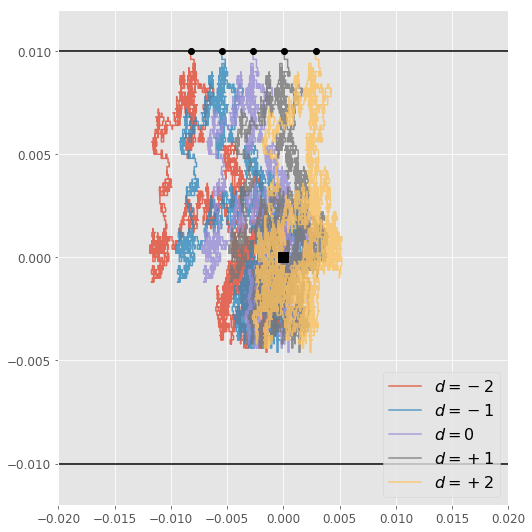

In [33]:
# Problem 5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pltparams = {'legend.fontsize': 16, 'axes.labelsize': 20, 'axes.titlesize': 20,
             'xtick.labelsize': 12, 'ytick.labelsize':12, 'figure.figsize': (7.5, 7.5),}
plt.rcParams.update(pltparams)

def model2RW(params,p0,deltapm):        # simulate Random-Walk for 1 transaction
    price = np.array([p0[0], p0[1]])    # initialize mid-prices for dealers p_1 and p_2
    cdp   = params['c']*params['dp']    # define random step size
    ddt   = params['d']*params['dt']    # define trend drift term
    Dt    = [price[0]-price[1]]         # initialize price difference as empty list
    At    = [np.average(price)]         # initialize avg price as empy list
    while np.abs(price[0]-price[1]) < params['L']:
        price=price+np.random.choice([-cdp,cdp],size=2) # random walk step for mid-prices Eq. (L4)
        price=price+ddt*deltapm         # Model 2 : add trend-following term in Eq. (L4)
        Dt.append(price[0]-price[1])
        At.append(np.average(price))
    return np.array(Dt),np.array(At)-At[0] # return difference array and average centered at zero
def plot5(ax, dvalues, labels):
    params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.25, 'M':1} # define model parameters
    p0 = [100.25, 100.25]
    deltapm = 0.003
    for dval,lbl in zip(dvalues, labels):
        np.random.seed(123456)
        params['d'] = dval
        Dt,At = model2RW(params, p0, deltapm) 
        ax.plot(At,Dt,alpha=0.8,label=lbl)    #plot RW
        ax.plot(At[-1],Dt[-1],marker='o',color='k') # plot last point
    ax.plot(0, 0, marker='s', color='k', markersize=10) # starting position
    ax.plot([-0.04,0.04],[params['L'],params['L']],color='k') #top absorbing boundary P=L
    ax.plot([-0.04,0.04],[-params['L'],-params['L']],color='k') #bottom absorbing boundary P=-L
    ax.set_ylim([-0.012, 0.012])
    ax.set_xlim([-0.02, 0.02])
    ax.legend(loc=4,framealpha=0.8)
    
%matplotlib inline
fig, ax = plt.subplots(figsize=(7.5,7.5))
plot5(ax, [-2.0,-1.0,0.0,1.0,2.0], [r'$d = -2$',r'$d = -1$',r'$d = 0$',r'$d = +1$',r'$d = +2$'])
ax.set_xlim([-0.020,0.020])
fig.tight_layout()
plt.show()

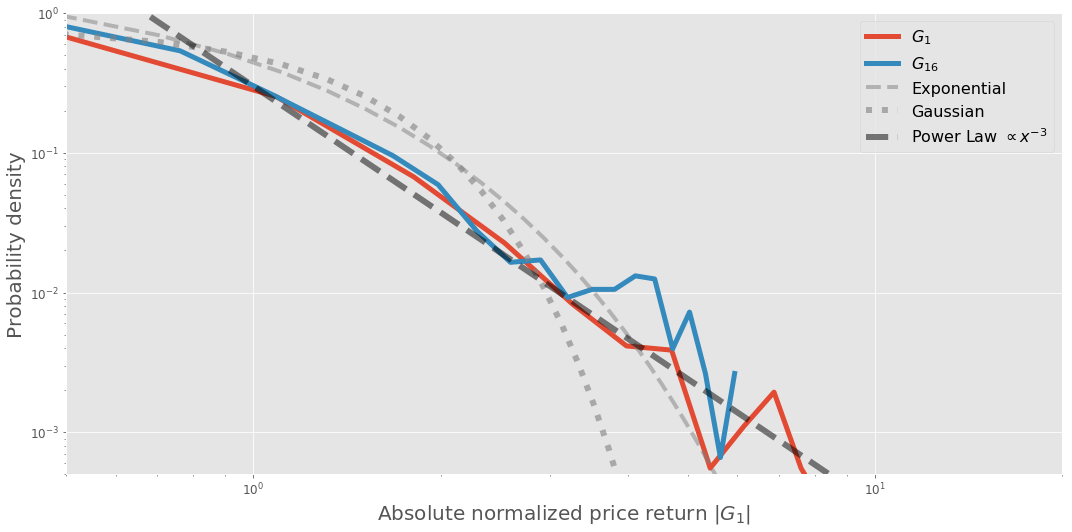

In [38]:
# Problem 6
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pltparams = {'legend.fontsize': 16, 'axes.labelsize': 20, 'axes.titlesize': 20,
             'xtick.labelsize': 12, 'ytick.labelsize':12, 'figure.figsize': (7.5, 7.5),}
plt.rcParams.update(pltparams)
def problem6(tau1, tau2):
    # Logarithmic return of price time series
    def logreturn(Pt,tau=1):
        return np.log(Pt[tau:]) - np.log(Pt[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
    # Normalize data to have unit variance (<(x - <x>)^2> = 1)
    def normalized(data):
        return (data/np.sqrt(np.var(data)))

    dmy, data = np.loadtxt('model2.txt', unpack=True)
    return normalized(logreturn(data, tau1)), normalized(logreturn(data,tau2))

def plot6(ax,g1,g16):
    def pdf(data,bins=50):
        hist,edges=np.histogram(data[~np.isnan(data)],bins=bins,density=True) # remove NaNs and compute histogram
        edges   = (edges[:-1] + edges[1:])/2.0 # get bar center
        nonzero = hist > 0.0                   # non-zero points 
        return edges[nonzero], hist[nonzero]

    for data,lbl in zip([g1,g16], [r'$G_1$', r'$G_{16}$']):
        edges, hist = pdf(np.abs(data), bins=20)
        ax.plot(edges, hist, lw=5, label=lbl)

    x = np.linspace(0.1, 10)
    ax.plot(x, 2*np.exp(-1.5*x),lw=4,color='gray',ls='--',alpha=0.5,label=r'Exponential')
    ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=6,ls=':',color='gray',alpha=0.6,label=r'Gaussian')
    ax.plot(x, 0.3*x**(-3), lw=6, color='k', ls='--', alpha=0.5, label=r'Power Law $\propto x^{-3}$')
    ax.semilogy()
    ax.semilogx()
    ax.set_xlim([5e-1,2e1])
    ax.set_ylim([5e-4,1])
    ax.legend()
    ax.set_xlabel(r'Absolute normalized price return $|G_1|$')
    ax.set_ylabel(r'Probability density')
    
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,7.5))
g1,g2 = problem6(1,16)
plot6(ax, g1, g2)
fig.tight_layout()
plt.show()

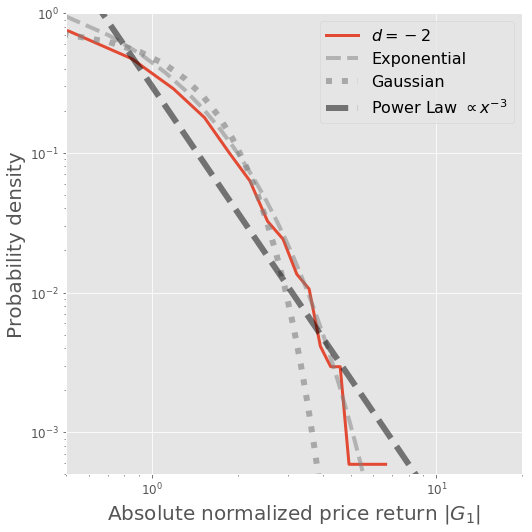

In [59]:
# Problem 7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pltparams = {'legend.fontsize': 16, 'axes.labelsize': 20, 'axes.titlesize': 20,
             'xtick.labelsize': 12, 'ytick.labelsize':12, 'figure.figsize': (7.5, 7.5),}
plt.rcParams.update(pltparams)
def problem7(tau):
    # Logarithmic return of price time series
    def logreturn(Pt,tau=1):
        return np.log(Pt[tau:]) - np.log(Pt[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
    # Normalize data to have unit variance (<(x - <x>)^2> = 1)
    def normalized(data):
        return (data/np.sqrt(np.var(data)))

    price = pd.read_csv('model2_M10_5d.txt', header=0, delim_whitespace=True,index_col=False)
    dprice= pd.DataFrame() #create empty frame
    for col in ['d+2','d+1','d0','d-1','d-2']: #populate frames with returns
        dprice[col] = normalized(logreturn(price[col].values,tau))
    return dprice

def plot7(ax,dprice):
    def pdf(data,bins=50):
        hist,edges=np.histogram(data[~np.isnan(data)],bins=bins,density=True) # remove NaNs and compute histogram
        edges   = (edges[:-1] + edges[1:])/2.0 # get bar center
        nonzero = hist > 0.0                   # non-zero points 
        return edges[nonzero], hist[nonzero]

    edges,hist = pdf(np.abs(dprice),bins=20)
    ax.plot(edges,hist,label=r'$d=-2$', lw=3)
    x = np.linspace(0.1, 10)
    ax.plot(x, 2*np.exp(-1.5*x),lw=4,color='gray',ls='--',alpha=0.5,label=r'Exponential')
    ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=6,ls=':',color='gray',alpha=0.6,label=r'Gaussian')
    ax.plot(x, 0.3*x**(-3), lw=6, color='k', ls='--', alpha=0.5, label=r'Power Law $\propto x^{-3}$')
    ax.semilogy()
    ax.semilogx()
    ax.set_xlim([5e-1,2e1])
    ax.set_ylim([5e-4,1])
    ax.legend()
    ax.set_xlabel(r'Absolute normalized price return $|G_1|$')
    ax.set_ylabel(r'Probability density')
    
%matplotlib inline
fig, ax = plt.subplots(figsize=(7.5,7.5))
dprice = problem7(1)
plot7(ax, dprice['d-2'])
fig.tight_layout()
plt.show()

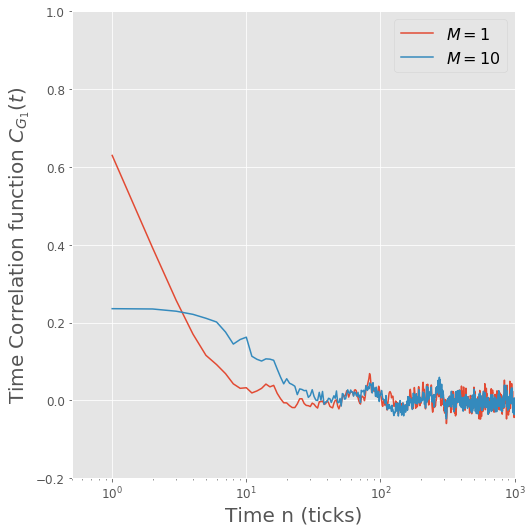

In [73]:
# Problem 8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pltparams = {'legend.fontsize': 16, 'axes.labelsize': 20, 'axes.titlesize': 20,
             'xtick.labelsize': 12, 'ytick.labelsize':12, 'figure.figsize': (7.5, 7.5),}
plt.rcParams.update(pltparams)
def problem8(colM10,tau=1):
    # Logarithmic return of price time series
    def logreturn(Pt,tau=1):
        return np.log(Pt[tau:]) - np.log(Pt[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
    # Normalize data to have unit variance (<(x - <x>)^2> = 1)
    def normalized(data):
        return (data/np.sqrt(np.var(data)))

    priceM1   = np.loadtxt('model2.txt', usecols=[1,])
    priceM10 = pd.read_csv('model2_M10_5d.txt', header=0, delim_whitespace=True, index_col=False)
    dprice    = pd.DataFrame()
    dprice['M1'] = normalized(logreturn(priceM1, tau))
    dprice['M10']= normalized(logreturn(priceM10[colM10].values,tau))
    return dprice

def plot8(ax,dprice1,dprice10):
    # compute self-correlation of vector v
    def auto_correlate(v):
        # np.correlate computes C_{v}[k] = sum_n v[n+k] * v[n]
        corr = np.correlate(v,v,mode="full") # correlate returns even array [0:2*nums-1] centered at nums-1
        return corr[len(v)-1:]/len(v) # take positive values and normalize by number of points
    ax.plot(auto_correlate(dprice1), label=r'$M=1$')
    ax.plot(auto_correlate(dprice10), label=r'$M=10$')
    ax.set_xlim(5e-1,1e3)
    ax.set_ylim(-0.2, 1.0)
    ax.legend()
    ax.semilogx()
    ax.set_xlabel(r'Time n (ticks)')
    ax.set_ylabel(r'Time Correlation function $C_{G_{1}}(t)$')

%matplotlib inline
fig, ax = plt.subplots(figsize=(7.5,7.5))
dprice = problem8('d+1')
plot8(ax,dprice['M1'], dprice['M10'])
fig.tight_layout()
plt.show()